In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

#import tensorflow as tf
import numpy as np
import pandas as pd
#import gpflow

#from tueplots import bundles

#from rcgp.rcgp import RCGPR
#from rcgp.w import IMQ

from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
# Relevance Pursuit Imports
import torch
import botorch

/opt/miniconda3/envs/RTGP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATA_PATH = '../../../data/'
RESULT_PATH = os.path.join(SCRIPT_DIR,'twitter-flash-crash/')
FILE_PATH = os.path.join(DATA_PATH,'DJI.txt')

In [5]:
DJI = pd.read_csv(FILE_PATH, header = None)
DJI.columns =['date', 'open', 'high', 'low', 'close']
DJI['date'] = pd.to_datetime(DJI['date']) #, infer_datetime_format=True)

# flash crash happened on the '2013-04-23'
# dates = ['2013-04-23']
# Uncomment this additional date for the counter-example that breaks the weighting
dates = ['2013-04-22', '2013-04-23'] #, '2013-04-24']
flash_crash_dji = DJI[DJI['date'].dt.date.astype(str).apply(lambda S: S in dates)]

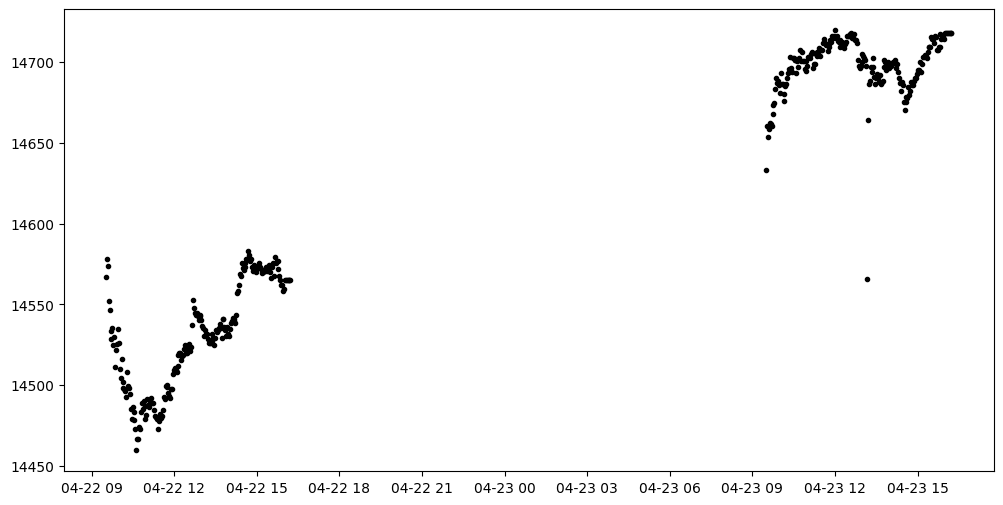

In [5]:
data = flash_crash_dji['open'].values.reshape(-1,1)[1::2]
dates = flash_crash_dji['date'].values.reshape(-1,1)[1::2]

arr1inds = dates[:,0].argsort()
data = data
dates = dates

figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(dates, data, 'k.', )

In [6]:
class MyScaler:
    def __init__(self):
        pass

    def fit(self, x):
        self.mu  = np.median(x)
        self.std = np.std(x)

    def transform(self, x):
        return (x-self.mu)/self.std

    def inverse_transform_mean(self, x):
        '''To transform mean'''
        return x*self.std + self.mu

    def inverse_transform_std(self, x):
        '''To transform standard deviation'''
        return x*self.std

In [7]:
class RobustScaler2(RobustScaler):

    def inverse_transform_mean(self, x):
        '''To transform mean'''
        return x*self.scale_ + self.center_

    def inverse_transform_std(self, x):
        '''To transform standard deviation'''
        return x*self.scale_

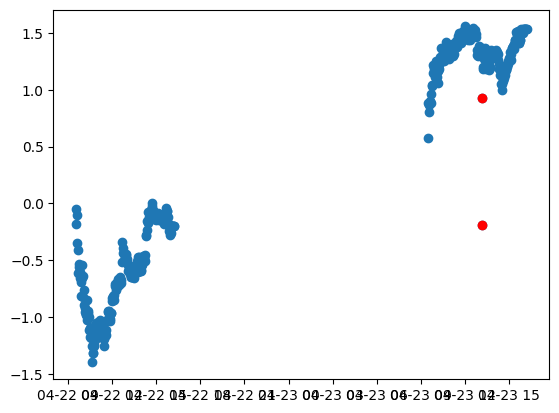

In [8]:
dates_float = dates.astype(np.float64)
x_scaler = StandardScaler()
y_scaler = MyScaler()
dates_normalised = x_scaler.fit_transform(dates_float)
y_scaler.fit(data)
data_normalised = y_scaler.transform(data)
plt.scatter(dates,data_normalised)
num_data = len(data_normalised)

# 202 is the number of data points for the flash crash date
outlier_indices = [num_data - 202 + 109, num_data - 202 + 110]
plt.scatter(dates[outlier_indices], data_normalised[outlier_indices], color = 'r')

In [9]:
# pred_dates = 
one_sec_in_ns = int(1e9)
one_min_in_ns = 60 * one_sec_in_ns
time_increments = list(range(0, int(max(dates)[0] - min(dates)[0]), one_min_in_ns))
pred_dates = np.array([min(dates) + inc for inc in time_increments])
pred_dates_normalised = x_scaler.transform(pred_dates)

In [10]:
"""standard_gp = gpflow.models.GPR(
    (dates_normalised, data_normalised),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=0.01,variance = 0.01),
    noise_variance = 0.01
)

opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)
print(res)
gpflow.utilities.print_summary(standard_gp, "notebook")

f_mean, f_var = standard_gp.predict_f(pred_dates_normalised, full_cov=False)

f_std = np.sqrt(f_var)

f_mean, f_std = y_scaler.inverse_transform_mean(f_mean), y_scaler.inverse_transform_std(f_std)
figsize = (12, 6)

plt.figure(figsize=figsize)
plt.plot(pred_dates[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    pred_dates[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
#plt.plot(dates, standard_gp.mean_function(dates_normalised))

plt.plot(dates, data, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(dates[0], dates[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()"""

'standard_gp = gpflow.models.GPR(\n    (dates_normalised, data_normalised),\n    kernel=gpflow.kernels.SquaredExponential(lengthscales=0.01,variance = 0.01),\n    noise_variance = 0.01\n)\n\nopt = gpflow.optimizers.Scipy()\nopt_options = dict()\nres = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)\nprint(res)\ngpflow.utilities.print_summary(standard_gp, "notebook")\n\nf_mean, f_var = standard_gp.predict_f(pred_dates_normalised, full_cov=False)\n\nf_std = np.sqrt(f_var)\n\nf_mean, f_std = y_scaler.inverse_transform_mean(f_mean), y_scaler.inverse_transform_std(f_std)\nfigsize = (12, 6)\n\nplt.figure(figsize=figsize)\nplt.plot(pred_dates[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= \'Standard GP Prediction\')\nplt.fill_between(\n    pred_dates[:,0],\n    f_mean[:,0] - 1.96 * f_std[:,0],\n    f_mean[:,0] + 1.96 * f_std[:,0],\n    facecolor= CB_color_cycle[2],\n    alpha=0.5,\n    label=\'95% IC\')\n#plt.plot(dates, standard_gp.mea

In [11]:
"""model = RCGPR(
    (dates_normalised, data_normalised),
    kernel=gpflow.kernels.SquaredExponential(),
    weighting_function=IMQ(1.5),
    noise_variance=standard_gp.likelihood.variance)

# setting C trainable to False is critical in getting this to work
learn_C = False
gpflow.set_trainable(model.weighting_function.C, learn_C)
gpflow.set_trainable(model.likelihood.variance, False)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
print(res)
gpflow.utilities.print_summary(model, "notebook")

f_mean_dsm, f_var_dsm = model.predict_f(pred_dates_normalised, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)

f_mean_dsm, f_std_dsm = y_scaler.inverse_transform_mean(f_mean_dsm), y_scaler.inverse_transform_std(f_std_dsm)

plt.figure(figsize=figsize)
plt.plot(pred_dates[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    pred_dates[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')

plt.plot(dates, data, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.legend()
plt.tight_layout()"""

'model = RCGPR(\n    (dates_normalised, data_normalised),\n    kernel=gpflow.kernels.SquaredExponential(),\n    weighting_function=IMQ(1.5),\n    noise_variance=standard_gp.likelihood.variance)\n\n# setting C trainable to False is critical in getting this to work\nlearn_C = False\ngpflow.set_trainable(model.weighting_function.C, learn_C)\ngpflow.set_trainable(model.likelihood.variance, False)\nopt = gpflow.optimizers.Scipy()\nopt_options = dict()\nres = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)\nprint(res)\ngpflow.utilities.print_summary(model, "notebook")\n\nf_mean_dsm, f_var_dsm = model.predict_f(pred_dates_normalised, full_cov=False)\n\nf_std_dsm = np.sqrt(f_var_dsm)\n\nf_mean_dsm, f_std_dsm = y_scaler.inverse_transform_mean(f_mean_dsm), y_scaler.inverse_transform_std(f_std_dsm)\n\nplt.figure(figsize=figsize)\nplt.plot(pred_dates[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= \'Robust GP Prediction\')\nplt.fill_between(\n    pre

# Relevance Pursuit

In [12]:
import math
from functools import partial
from time import perf_counter
from typing import List, Mapping, Optional, Tuple, Union

import gpytorch
import numpy as np

import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP, SingleTaskVariationalGP
from botorch.models.transforms.input import InputTransform, Normalize
from botorch.models.transforms.outcome import OutcomeTransform, Standardize
#from botorch_fb.models.map_saas import LogTransformedInterval

from botorch.models.relevance_pursuit import (
    backward_relevance_pursuit,
    forward_relevance_pursuit,
    get_posterior_over_support,
)

from botorch.models.likelihoods.sparse_outlier_noise import (
    SparseOutlierGaussianLikelihood,
    SparseOutlierNoise,
)
"""from botorch_fb.relevance_pursuit.robust_gp.trimmed_mll import (
    getFinalModelForPrediction,
    residualNuTrimmedGP,
)"""
from gpytorch.kernels import MaternKernel, ScaleKernel

from gpytorch.likelihoods import GaussianLikelihood, Likelihood, StudentTLikelihood
from gpytorch.likelihoods.noise_models import HomoskedasticNoise
from gpytorch.means import ConstantMean
from gpytorch.mlls import VariationalELBO
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.priors import NormalPrior
from gpytorch.priors.torch_priors import GammaPrior, LogNormalPrior
from gpytorch.variational import VariationalStrategy
from sklearn.preprocessing import PowerTransformer
from gpytorch.constraints import Interval
from torch import Tensor

In [13]:

class LogTransformedInterval(Interval):
    def __init__(
        self,
        lower_bound: Tensor,
        upper_bound: Tensor,
        initial_value: Optional[Tensor] = None,
    ):
        """Modification of the GPyTorch interval class.

        The Interval class in GPyTorch will map the parameter to the range [0, 1] before
        applying the inverse transform. We don't want to do this when using log as an
        inverse transform. This class will skip this step and apply the log transform
        directly to the parameter values so we can optimize log(parameter) under the bound
        constraints log(lower) <= log(parameter) <= log(upper).
        """
        super().__init__(
            lower_bound=lower_bound,
            upper_bound=upper_bound,
            transform=torch.exp,
            inv_transform=torch.log,
            initial_value=initial_value,
        )

        # Save the untransformed initial value
        self.register_buffer(
            "initial_value_untransformed",
            torch.tensor(initial_value).to(self.lower_bound)
            if initial_value is not None
            else None,
        )

        max_bound = torch.max(self.upper_bound)
        min_bound = torch.min(self.lower_bound)
        if max_bound == math.inf or min_bound == -math.inf:
            raise RuntimeError(
                "Cannot make an Interval directly with non-finite bounds. Use a "
                "derived class like GreaterThan or LessThan instead."
            )

    def transform(self, tensor):
        if not self.enforced:
            return tensor

        transformed_tensor = self._transform(tensor)
        return transformed_tensor

    def inverse_transform(self, transformed_tensor):
        if not self.enforced:
            return transformed_tensor

        tensor = self._inv_transform(transformed_tensor)
        return tensor

In [14]:
def get_gp_modules(dim: int) -> Tuple[ConstantMean, ScaleKernel]:
    mean_module = ConstantMean(constant_prior=NormalPrior(0.0, 1.0))
    covar_module = ScaleKernel(
        MaternKernel(
            ard_num_dims=dim,
            lengthscale_constraint=LogTransformedInterval(
                0.01, 100.00, initial_value=0.05,
            ),
        ),
    )
    return mean_module, covar_module


def get_model(
    likelihood: Likelihood,
    X: Tensor,
    Y: Tensor,
    outcome_transform: Optional[OutcomeTransform] = None,
    input_transform: Optional[InputTransform] = None,
) -> SingleTaskGP:
    mean_module, covar_module = get_gp_modules(dim=X.shape[-1])
    return SingleTaskGP(
        train_X=X,
        train_Y=Y,
        mean_module=mean_module,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=outcome_transform,
        input_transform=input_transform,
    )


def get_robust_model(
    X: Tensor,
    Y: Tensor,
    numbers_of_outliers: Optional[Union[int, List[int]]] = None,
    fractions_of_outliers: Optional[List[float]] = None,
    fit_inlier_only_model: bool = False,
    min_noise: float = (5e-3) ** 2,
    max_noise: float = 1.0,
    initial_support: Optional[List[int]] = None,
    prior_mean_of_support: Optional[int] = None,
    convex_parameterization: bool = True,
    timeout_sec: Optional[float] = None,
    input_transform: Optional[InputTransform] = None,
    outcome_transform: Optional[OutcomeTransform] = None,
    use_forward_algorithm: bool = False,
    select_posterior_mean_of_support: bool = False,
    reset_parameters: bool = True,
    reset_dense_parameters: bool = False,
) -> SingleTaskGP:
    """Trains a robust GP model.

    Args:
        X: The training inputs.
        Y: The training outputs.
        numbers_of_outliers: An optional list of numbers of outliers to consider
            during the relevance pursuit algorithm. If None, the algorithm will
            default to considering len(Y) * fractions_of_outliers. IDEA: this could be
            generalized to type of bisection search over the number of outliers, or one
            could use exponential_sparsity_levels(n=n, base=2, reverse=True).
        fractions_of_outliers: An optional list of fractions of outliers to consider if
            numbers_of_outliers is None. By default: [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5].
        fit_inlier_only_model: If True, the model will be fit to the inlier data
            only, after running the outlier detection algorithm.
        min_noise: The lower bound for the noise level.
        max_noise: The upper bound for the noise level.
        initial_support: A list of indices of the initial support set.
        prior_mean_of_support: The mean value for the default exponential prior
            distribution over the support size.
        convex_parameterization: If True, the convex parameterization of the outlier
            variances is used, which allows us to use looser convergence tolerances as
            the optimizer does not have to escape flat non-convex regions.
        use_forward_algorithm: Whether or not to use the forward algorithm.
        select_posterior_mean_of_support: If True, we will choose the model whose
            support is closest to the posterior mean of the support size. Otherwise, we
            will choose the maximum-a-posteriori (MAP) estimate.
        reset_parameters: If True, we will reset the parameters of the model after each
            iteration of the relevance pursuit algorithm.
    """
    # standardize by default
    if outcome_transform is None:
        outcome_transform = Standardize(m=Y.shape[-1])

    base_noise = HomoskedasticNoise(
        noise_constraint=LogTransformedInterval(min_noise, max_noise),
        noise_prior=None,  
    )
    input_transform = Normalize(d=X.shape[-1])
    likelihood = SparseOutlierGaussianLikelihood(
        base_noise=base_noise,
        dim=X.shape[0],
        convex_parameterization=convex_parameterization,
    )
    model = get_model(
        likelihood=likelihood,
        X=X,
        Y=Y,
        input_transform=input_transform,
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model=model, likelihood=model.likelihood)
    sparse_module = model.likelihood.noise_covar

    if numbers_of_outliers is None:
        if fractions_of_outliers is None:
            fractions_of_outliers = [
                0.0,
                0.05,
                0.1,
                0.15,
                0.2,
                0.3,
                0.4,
                0.5,
                0.75,
                1.0,
            ]

        # list from which BMC chooses
        n = len(initial_support) if initial_support is not None else len(Y)
        numbers_of_outliers = [int(p * n) for p in fractions_of_outliers]

    # force number_of_outliers to be a list
    if isinstance(numbers_of_outliers, int):
        numbers_of_outliers = [numbers_of_outliers]

    if prior_mean_of_support is None:
        prior_mean_of_support = int(len(Y) * 0.2)

    tol = 1e-9
    optimizer_kwargs: Mapping[str, Union[float, Mapping[str, Union[int, float]]]] = {
        "options": {"maxiter": 1024, "ftol": tol, "gtol": tol},
    }
    if timeout_sec is not None:
        optimizer_kwargs["timeout_sec"] = timeout_sec / len(numbers_of_outliers)
    optimize = (
        forward_relevance_pursuit
        if use_forward_algorithm
        else backward_relevance_pursuit
    )
    sparse_module, model_trace = optimize(
        sparse_module=sparse_module,
        mll=mll,
        sparsity_levels=numbers_of_outliers,
        reset_parameters=reset_parameters,
        reset_dense_parameters=reset_dense_parameters,
        optimizer_kwargs=optimizer_kwargs,
        initial_support=initial_support,
        record_model_trace=True,
    )

    # Bayesian model comparison
    support_size, bmc_probabilities = get_posterior_over_support(
        SparseOutlierNoise, model_trace, prior_mean_of_support=prior_mean_of_support
    )
    mean_support = (support_size * bmc_probabilities).sum()
    if select_posterior_mean_of_support:
        map_index = (mean_support - support_size).abs().argmin()
    else:
        map_index = torch.argmax(bmc_probabilities)

    model = model_trace[map_index]  # choosing model with highest BMC probability
    sparse_module = model.likelihood.noise_covar

    if fit_inlier_only_model:
        X_inlier = X[~sparse_module.is_active]
        Y_inlier = Y[~sparse_module.is_active]
        likelihood = GaussianLikelihood(
            noise_constraint=LogTransformedInterval(min_noise, max_noise),
            noise_prior=GammaPrior(concentration=0.9, rate=10.0),
        )
        inlier_model = get_model(
            X=X_inlier,
            Y=Y_inlier,
            likelihood=likelihood,
            outcome_transform=Standardize(m=Y.shape[-1]),
        )
        mll = ExactMarginalLogLikelihood(
            model=inlier_model, likelihood=inlier_model.likelihood
        )
        fit_gpytorch_mll(mll, optimizer_kwargs=optimizer_kwargs)
        model = mll.model

    return model


In [15]:
# dates_normalised, data_normalised
X = torch.tensor(dates_normalised)
Y = torch.tensor(data_normalised)
rp_model = get_robust_model(
    X=X,
    Y=Y,
    use_forward_algorithm=True,
    convex_parameterization=False,
)
X_pred = torch.tensor(pred_dates_normalised)
post_X = rp_model.posterior(X_pred, observation_noise=False)
post_mean = post_X.mean.squeeze(-1).detach()
post_var = post_X.variance.squeeze(-1).detach()
post_std = post_var.sqrt()
rp_mean = y_scaler.inverse_transform_mean(post_mean)
rp_std = y_scaler.inverse_transform_std(post_std)

In [16]:
rp_model.covar_module.base_kernel.lengthscale

tensor([[0.0221]], dtype=torch.float64, grad_fn=<ExpBackward0>)

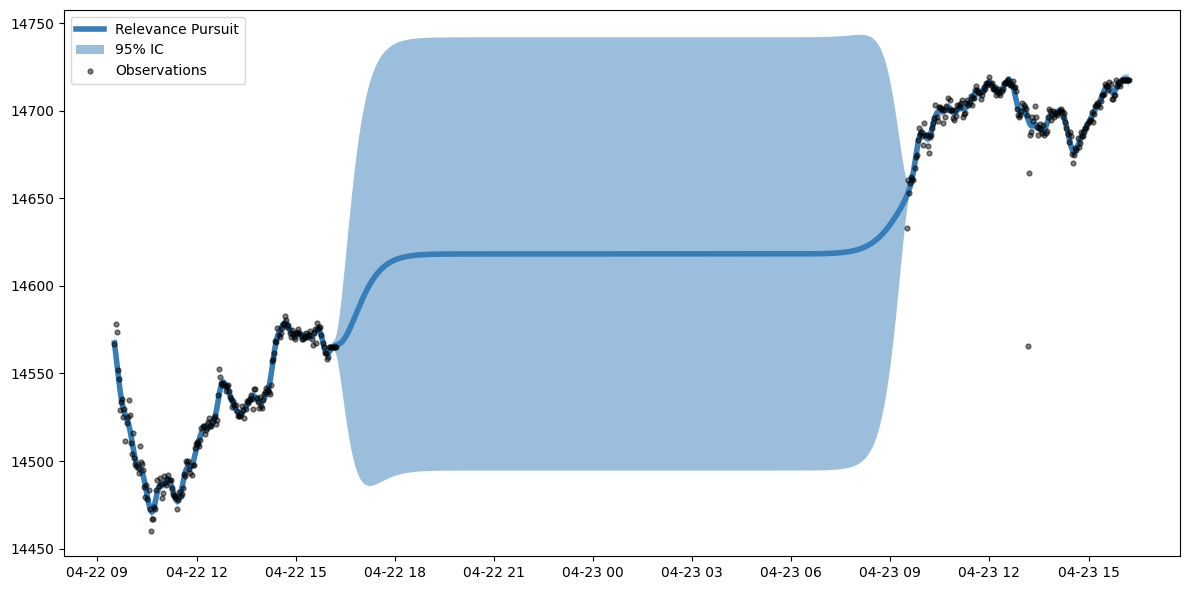

In [21]:
plt.figure(figsize=figsize)
plt.plot(pred_dates[:,0], rp_mean, c=CB_color_cycle[0], lw=4, label= 'Relevance Pursuit')
plt.fill_between(
    pred_dates[:,0],
    rp_mean - 1.96 * rp_std,
    rp_mean + 1.96 * rp_std,
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')

plt.plot(dates, data, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.legend()
plt.tight_layout()

In [26]:
np.savetxt("relevance_pursuit_mean.txt", rp_mean.numpy())
np.savetxt("relevance_pursuit_std.txt", rp_std.numpy())
np.savetxt("relevant_pursuit_dates.txt", pred_dates[:,0])

In [16]:
is_23rd = (dates <= np.datetime64("2013-04-23")).squeeze(-1)
is_23rd.shape, dates[is_23rd].shape

((405,), (202, 1))

In [17]:
two_hours_before_open_24 = pred_dates > dates[~is_23rd].min() - 2 * 60 * one_min_in_ns
two_hours_after_close_23 = pred_dates < dates[is_23rd].max() + 2 * 60 * one_min_in_ns
two_hours_after_close_23

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

(14400.0, 14800.0)

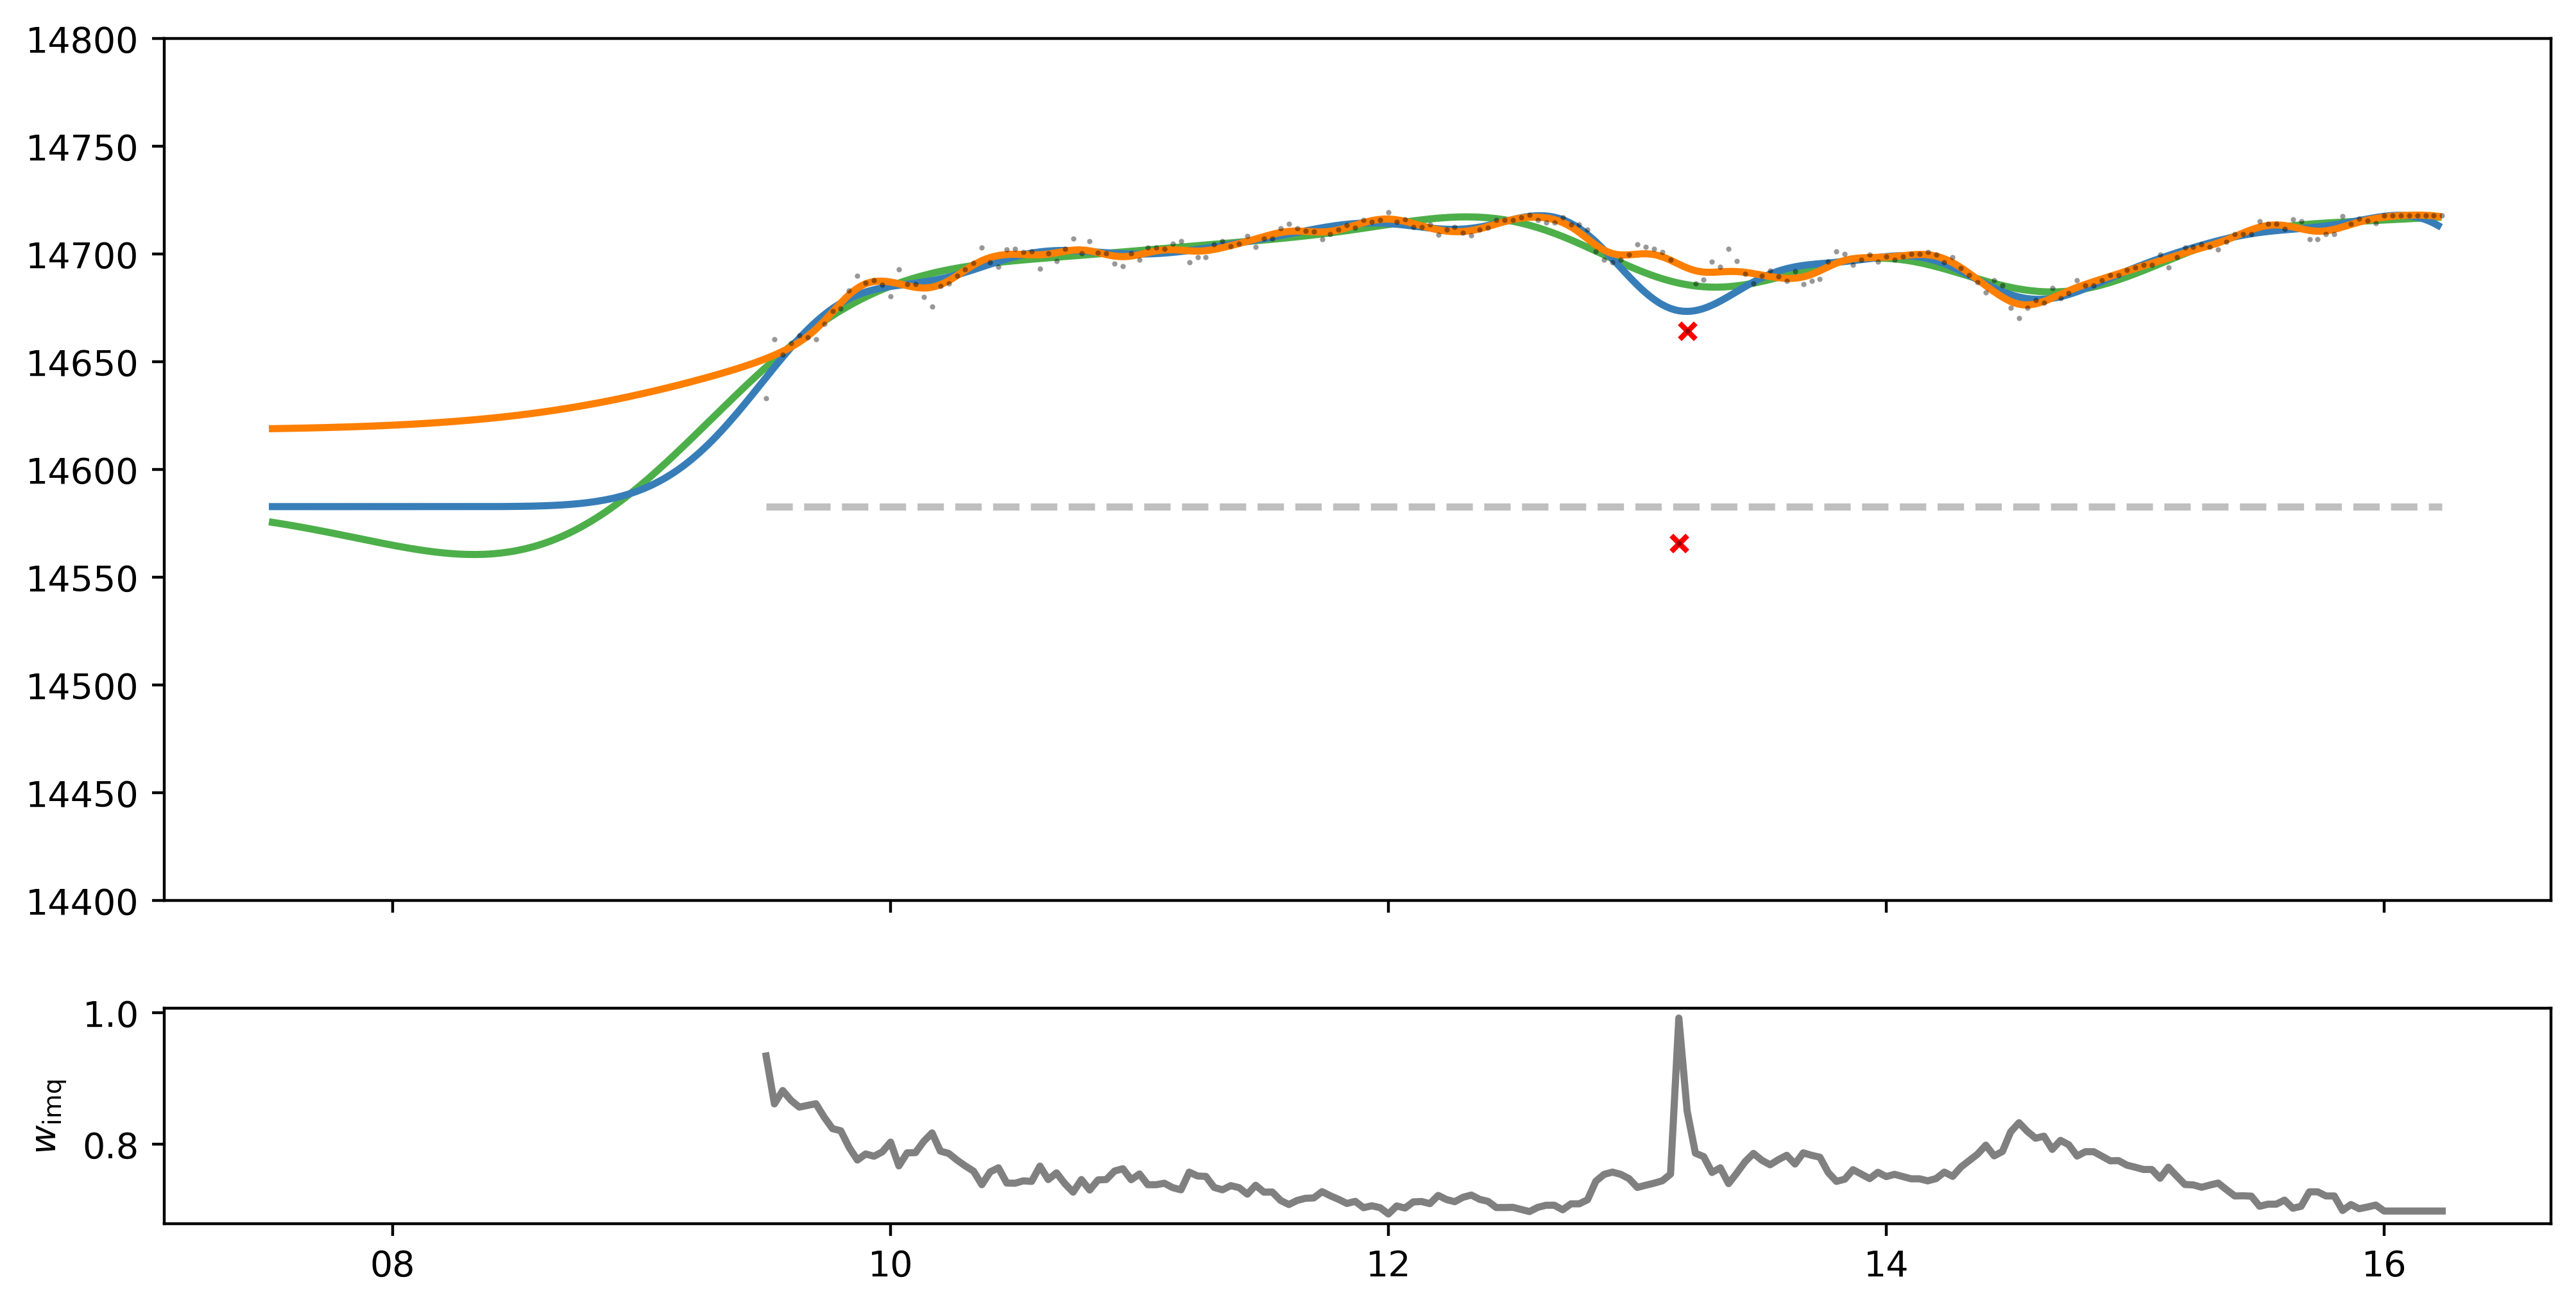

In [18]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib as mpl
# with plt.rc_context(bundles.aistats2023()):
# fig, ax = plt.subplots(nrows= 2, sharex = True , figsize= (4, 3),dpi = 400, gridspec_kw={'height_ratios': [4,1]})
# figsize = (4, 2)
# figsize = (2, 3)
lw = 2

fig, ax = plt.subplots(nrows= 2, sharex = True , figsize=figsize,dpi = 400, gridspec_kw={'height_ratios': [4,1]})

# for ind in [is_23rd, ~is_23rd]:
#     ax[0].plot(dates[ind, 0], f_mean[ind][:, 0], c=CB_color_cycle[2], lw=lw, label= 'GP')
#     rcgp_name = 'RCGP (GPR Noise)'
#     ax[0].plot(dates[ind, 0], f_mean_dsm[ind][:, 0], c=CB_color_cycle[0], lw=lw, label=rcgp_name)
#     ax[0].plot(dates[ind, 0], rp_mean[torch.tensor(ind)], c=CB_color_cycle[1], lw=lw, label= 'Relevance Pursuit')
#     ax[1].plot(dates[ind, 0], model.weighting_function.W(dates_normalised, data_normalised)[ind], lw=lw, color="gray")

# NOTE: Can focus on individual days by commenting in / out the 
# following indices.
plot_23rd = False

if plot_23rd:
    day_ind = two_hours_after_close_23
else:
    day_ind = two_hours_before_open_24
    
ax[0].plot(pred_dates[day_ind], f_mean[day_ind], c=CB_color_cycle[2], lw=lw, label= 'GP')
rcgp_name = 'RCGP (GP Noise)'
ax[0].plot(pred_dates[day_ind], f_mean_dsm[day_ind], c=CB_color_cycle[0], lw=lw, label=rcgp_name)
ax[0].plot(pred_dates[day_ind], rp_mean[day_ind[:, 0]], c=CB_color_cycle[1], lw=lw, label= 'Relevance Pursuit')

for ind in ([is_23rd] if plot_23rd else [~is_23rd]):
    ax[1].plot(dates[ind, 0], model.weighting_function.W(dates_normalised, data_normalised)[ind], lw=lw, color="gray")\

    ax[0].hlines(np.median(data), dates[ind][0], dates[ind][-1], label='Prior mean', lw=lw, ls='--', alpha=0.5, color='grey')
    mask = np.ones(data.shape, bool)
    mask[[109, 110]] = False
    # mask[~is_23rd] = False
    mask[~ind] = False
    # ax[0].set_ylabel('DJIA index')
    ax[0].plot(dates[mask], data[mask], 'k.', ms=1, alpha=0.4)

    if not plot_23rd:
        ax[0].scatter(dates[outlier_indices], data[outlier_indices], marker = 'x', alpha=1, color= 'r', s=20, label = 'Sell off')

ax[1].xaxis.set_major_locator(mdates.HourLocator())
date_form = DateFormatter("%H")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].set_xticks(ax[1].get_xticks()[::2])
# ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$w_{\mathrm{imq}}$')
ax[0].set_ylim(14400, 14800)

# ax[0].legend(loc='upper left', fontsize=7.5, bbox_to_anchor=(-0.015, 1.03))
# ax[0].legend(loc='lower right', fontsize=6.5) #, bbox_to_anchor=(0.15,0.75))
# fig.savefig(f'figures/flashcrash_and_prior_day_rp_{learn_C=}.pdf', format="pdf", bbox_inches= "tight")
# fig.savefig(f'figures/flashcrash_and_prior_day_rp_{learn_C=}_1.pdf', format="pdf", bbox_inches= "tight", dpi=300)
# fig.savefig(f'figures/flashcrash_and_prior_day_rp_{learn_C=}_2.pdf', format="pdf", bbox_inches= "tight", dpi=300)

Text(0, 0.5, '$w_{\\mathrm{imq}}$')

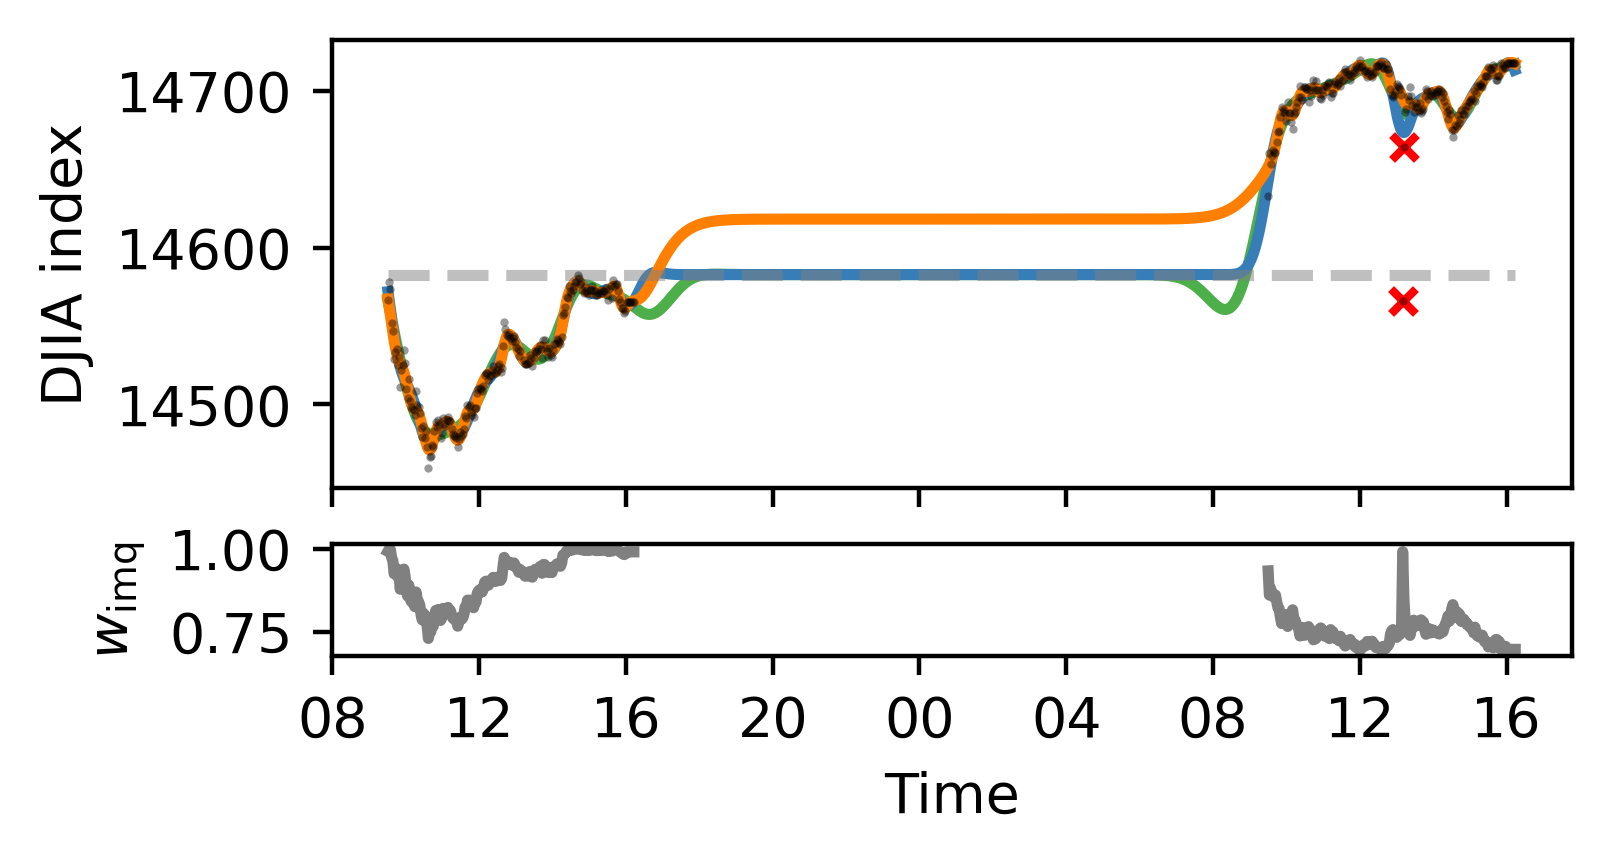

In [19]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib as mpl
# with plt.rc_context(bundles.aistats2023()):
# fig, ax = plt.subplots(nrows= 2, sharex = True , figsize= (4, 3),dpi = 400, gridspec_kw={'height_ratios': [4,1]})
figsize = (4, 2)
lw = 2

fig, ax = plt.subplots(nrows= 2, sharex = True , figsize=figsize, dpi = 400, gridspec_kw={'height_ratios': [4,1]})

# for ind in [is_23rd, ~is_23rd]:
#     ax[0].plot(dates[ind, 0], f_mean[ind][:, 0], c=CB_color_cycle[2], lw=lw, label= 'GP')
#     rcgp_name = 'RCGP (GPR Noise)'
#     ax[0].plot(dates[ind, 0], f_mean_dsm[ind][:, 0], c=CB_color_cycle[0], lw=lw, label=rcgp_name)
#     ax[0].plot(dates[ind, 0], rp_mean[torch.tensor(ind)], c=CB_color_cycle[1], lw=lw, label= 'Relevance Pursuit')
#     ax[1].plot(dates[ind, 0], model.weighting_function.W(dates_normalised, data_normalised)[ind], lw=lw, color="gray")

ax[0].plot(pred_dates[:, 0], f_mean[:, 0], c=CB_color_cycle[2], lw=lw, label= 'GP')
rcgp_name = 'RCGP (GPR Noise)'
ax[0].plot(pred_dates[:, 0], f_mean_dsm[:, 0], c=CB_color_cycle[0], lw=lw, label=rcgp_name)
ax[0].plot(pred_dates[:, 0], rp_mean, c=CB_color_cycle[1], lw=lw, label= 'Relevance Pursuit')

for ind in [is_23rd, ~is_23rd]:
    ax[1].plot(dates[ind, 0], model.weighting_function.W(dates_normalised, data_normalised)[ind], lw=lw, color="gray")\

ax[0].hlines(np.median(data),dates[0],dates[-1], label='Prior mean', lw=lw, ls='--', alpha=0.5, color='grey')

mask = np.ones(data.shape, bool)
mask[[109,110]] = False
ax[0].set_ylabel('DJIA index')
ax[0].plot(dates[mask], data[mask], 'k.', ms=1, alpha=0.4)
ax[0].scatter(dates[outlier_indices], data[outlier_indices], marker = 'x', alpha=1, color= 'r', s=20, label = 'Sell off')
ax[1].xaxis.set_major_locator(mdates.HourLocator())
date_form = DateFormatter("%H")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].set_xticks(ax[1].get_xticks()[::4])
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$w_{\mathrm{imq}}$')